In [1]:
import os
import pandas as pd
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import re
import string
import nltk
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns

# Download necessary nltk data
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Set random seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed(42)

# Preprocessing functions
def clean_text(text):
    # Remove punctuation and convert text to lowercase
    text = re.sub(f"[{string.punctuation}]", " ", text)
    text = text.lower()

    # Tokenization and lemmatization
    tokens = nltk.word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)

# Load dataset and clean 'Opinion' column
labeled_data_path = r"C:\Users\andyb\Desktop\Coding Files\pointview\datasets\labeled_dataset.csv"
df = pd.read_csv(labeled_data_path)

# Remove duplicate rows based on the 'Opinion' column (if a review has already been seen)
df = df.drop_duplicates(subset=['Opinion'], keep='first')

# Apply the clean_text function to the 'Opinion' column
df['Opinion'] = df['Opinion'].apply(clean_text)

# Remove rows with NaN values in 'Sentiment' column
df = df.dropna(subset=['Sentiment'])

# Convert sentiment labels to integers
label_mapping = {'Positive': 1, 'Negative': 0}
df['Sentiment'] = df['Sentiment'].map(label_mapping)

# Split the dataset into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Remove duplicates in the training and test sets, if needed
train_df = train_df.drop_duplicates(subset=['Opinion'], keep='first')
test_df = test_df.drop_duplicates(subset=['Opinion'], keep='first')


# Tokenize the dataset
MAX_WORDS = 10000
MAX_LEN = 512
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['Opinion'])

# Convert text to sequences and pad them
train_sequences = tokenizer.texts_to_sequences(train_df['Opinion'])
train_padded = pad_sequences(train_sequences, maxlen=MAX_LEN, padding='post', truncating='post')

test_sequences = tokenizer.texts_to_sequences(test_df['Opinion'])
test_padded = pad_sequences(test_sequences, maxlen=MAX_LEN, padding='post', truncating='post')

# Prepare the labels
train_labels = np.array(train_df['Sentiment'])
test_labels = np.array(test_df['Sentiment'])

# Build BiLSTM model
model = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=128, input_length=MAX_LEN),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification (Positive/Negative)
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training the model
history = model.fit(train_padded, train_labels, epochs=5, batch_size=32, validation_data=(test_padded, test_labels))

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_padded, test_labels)
print(f"Test accuracy: {test_acc}")

# Predict on the test set
predictions = (model.predict(test_padded) > 0.5).astype("int32")

# Classification report
print(classification_report(test_labels, predictions, target_names=['Negative', 'Positive']))

# Save the model
model.save("bilstm_sentiment_model.h5")

# Predict sentiment for new data
def predict_sentiment_bilstm(review):
    review = clean_text(review)
    sequence = tokenizer.texts_to_sequences([review])
    padded_sequence = pad_sequences(sequence, maxlen=MAX_LEN, padding='post', truncating='post')
    sentiment = model.predict(padded_sequence)
    return "Positive" if sentiment > 0.5 else "Negative"

# Example usage
review = "The staff were very helpful and friendly"
print(f"Review: {review}")
print(f"Predicted Sentiment: {predict_sentiment_bilstm(review)}")

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)  # Creates a subplot for accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss plot
plt.subplot(1, 2, 2)  # Creates a subplot for loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Show the plots
plt.tight_layout()
plt.show()

# Aspect-Based Sentiment Analysis

# Base directory containing the hotel reviews
base_dir = r"C:\Users\andyb\Desktop\Coding Files\PointView\datasets\hotel_aspect_based_dataset"
output_dir = r"C:\Users\andyb\Desktop\Coding Files\PointView\datasets\sentiment_results_biLSTM"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

def extract_aspects(review, aspects_list):
    return [aspect for aspect in aspects_list if aspect.lower() in review.lower()]

# Process each hotel directory
specific_kpis = ["food", "staff", "comfort & facilities", "value for money"]  # Example aspects
for hotel_dir in os.listdir(base_dir):
    hotel_path = os.path.join(base_dir, hotel_dir)
    
    if os.path.isdir(hotel_path):
        combined_df = pd.DataFrame()
        for csv_file in os.listdir(hotel_path):
            if csv_file.endswith('.csv'):
                file_path = os.path.join(hotel_path, csv_file)
                temp_df = pd.read_csv(file_path)
                combined_df = pd.concat([combined_df, temp_df], ignore_index=True)

        # Remove duplicates in the actual dataset
        combined_df = combined_df.drop_duplicates(subset=['Review Content'], keep='first')

        combined_df['Aspects'] = combined_df['Review Content'].apply(lambda x: extract_aspects(x, specific_kpis))
        combined_df['Aspects'] = combined_df['Aspects'].apply(lambda x: x if x else [])

        combined_df['Sentiment_Results'] = combined_df.apply(
            lambda row: {aspect: predict_sentiment_bilstm(row['Review Content']) for aspect in row['Aspects']},
            axis=1
        )

        # Initialize dictionary to track positive/negative counts for each KPI
        aspect_sentiments = {aspect: {'positive': 0, 'negative': 0} for aspect in specific_kpis}

        # Count the positive and negative sentiments for each aspect
        for index, row in combined_df.iterrows():
            for aspect, sentiment in row['Sentiment_Results'].items():
                if sentiment == "Positive":
                    aspect_sentiments[aspect]['positive'] += 1
                else:
                    aspect_sentiments[aspect]['negative'] += 1
        
        # Calculate sentiment percentages for each aspect
        total_reviews = len(combined_df)
        for aspect, counts in aspect_sentiments.items():
            counts['positive_percent'] = (counts['positive'] / total_reviews) * 100
            counts['negative_percent'] = (counts['negative'] / total_reviews) * 100

        # Save the sentiment analysis results to a CSV file
        hotel_output_dir = os.path.join(output_dir, hotel_dir)
        if not os.path.exists(hotel_output_dir):
            os.makedirs(hotel_output_dir)

        output_file_path = os.path.join(hotel_output_dir, f"{hotel_dir}_sentiment_analysis.csv")
        output_df = pd.DataFrame(aspect_sentiments).T
        output_df.to_csv(output_file_path)

        print(f"Processed {hotel_dir}, results saved to {output_file_path}")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\andyb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\andyb\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\andyb\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
c:\Users\andyb\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 64s 292ms/step - accuracy: 0.0749 - loss: nan - val_accuracy: 0.0488 - val_loss: nan
Epoch 2/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 53s 276ms/step - accuracy: 0.0531 - loss: nan - val_accuracy: 0.0488 - val_loss: nan
Epoch 3/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 36s 190ms/step - accuracy: 0.0531 - loss: nan - val_accuracy: 0.0488 - val_loss: nan
Epoch 4/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 40s 209ms/step - accuracy: 0.0531 - loss: nan - val_accuracy: 0.0488 - val_loss: nan
Epoch 5/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 34s 175ms/step - accuracy: 0.0531 - loss: nan - val_accuracy: 0.0488 - val_loss: nan
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.0586 - loss: nan
Test accuracy: 0.04879635572433472
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step


c:\Users\andyb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_array_api.py:290: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)


ValueError: Input y_true contains NaN.

c:\Users\andyb\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


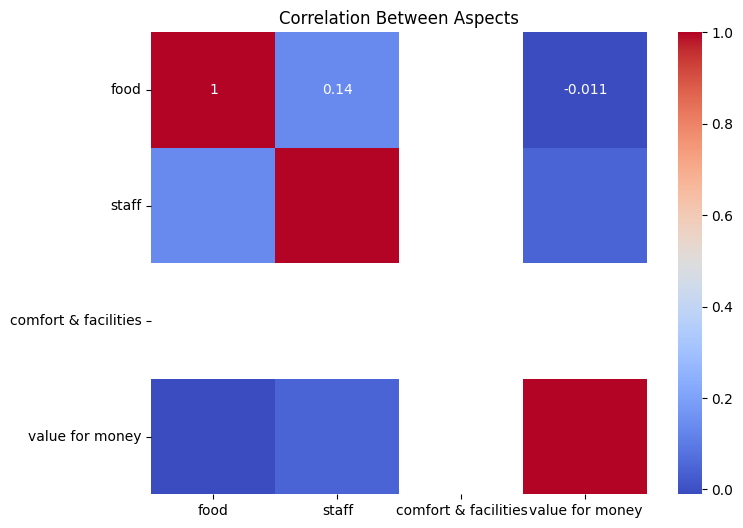

In [3]:
# Initialize a new DataFrame for the aspect sentiments (positive=1, negative=0)
aspect_sentiments_df = pd.DataFrame({
    aspect: combined_df['Sentiment_Results'].apply(lambda x: 1 if x.get(aspect) == 'Positive' else 0)
    for aspect in specific_kpis
})

# Calculate correlation matrix
correlation_matrix = aspect_sentiments_df.corr()

# Plot correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Between Aspects')
plt.show()

In [4]:
# Calculate and print standard deviation for sentiment results per aspect
for aspect in specific_kpis:
    sentiments = combined_df['Sentiment_Results'].apply(lambda x: 1 if x.get(aspect) == 'Positive' else 0)
    sentiment_counts = pd.Series(sentiments).value_counts(normalize=True) * 100
    std_dev = sentiment_counts.std()  # Calculating standard deviation
    print(f'Standard deviation for {aspect}: {std_dev}')

Standard deviation for food: 54.27998112842792
Standard deviation for staff: 34.07693023738371
Standard deviation for comfort & facilities: nan
Standard deviation for value for money: 68.78258612490364


In [4]:
import pandas as pd
import os

# Define the output directory where sentiment results are saved
output_dir = r"C:\Users\andyb\Desktop\Coding Files\PointView\datasets\sentiment_results_biLSTM"

# Function to load and display sentiment results from all hotels
def load_and_display_sentiment_results(output_dir):
    for hotel_dir in os.listdir(output_dir):
        hotel_path = os.path.join(output_dir, hotel_dir)
        
        if os.path.isdir(hotel_path):  # Check if it's a directory
            for csv_file in os.listdir(hotel_path):
                if csv_file.endswith('_sentiment_analysis.csv'):
                    file_path = os.path.join(hotel_path, csv_file)
                    
                    # Load the CSV file into a DataFrame
                    df = pd.read_csv(file_path, index_col=0)
                    
                    # Display the DataFrame
                    print(f"Sentiment Analysis for {hotel_dir}:")
                    print(df)
                    print("\n" + "="*50 + "\n")

# Call the function to display all sentiment results
load_and_display_sentiment_results(output_dir)


Sentiment Analysis for 1_bai_hotel:
                      positive  negative  positive_percent  negative_percent
food                    1109.0      48.0         27.457291          1.188413
staff                   1689.0      72.0         41.817282          1.782619
comfort & facilities       1.0       0.0          0.024759          0.000000
value for money           48.0       6.0          1.188413          0.148552


Sentiment Analysis for 2_dusit_thani_mactan:
                      positive  negative  positive_percent  negative_percent
food                     547.0      44.0         28.972458          2.330508
staff                    891.0      54.0         47.192797          2.860169
comfort & facilities       0.0       0.0          0.000000          0.000000
value for money            8.0       5.0          0.423729          0.264831


Sentiment Analysis for 3_fairfield_by_marriott_cebu:
                      positive  negative  positive_percent  negative_percent
food           